# Prompt Cache Lab - Multiturn Chat

# 사전 설정

In [1]:
%load_ext autoreload
%autoreload 2
%pip install ipywidgets
%pip install boto3 botocore --upgrade
%pip install pandas
%pip install matplot


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3, botocore
retry_config = botocore.config.Config(
    retries={"max_attempts": 1, "mode": "standard"}
)
session = boto3.Session(
    region_name='us-west-2'
)

bedrock_client = session.client("bedrock-runtime", config=retry_config)

print ("\n== FM lists ==")
model_list = session.client("bedrock").list_foundation_models()['modelSummaries']
print('\n'.join([model['modelId'] for model in model_list if model['modelId'].startswith('anth')]))


== FM lists ==
anthropic.claude-3-5-sonnet-20241022-v2:0:18k
anthropic.claude-3-5-sonnet-20241022-v2:0:51k
anthropic.claude-3-5-sonnet-20241022-v2:0:200k
anthropic.claude-3-5-sonnet-20241022-v2:0
anthropic.claude-3-7-sonnet-20250219-v1:0
anthropic.claude-3-5-haiku-20241022-v1:0
anthropic.claude-instant-v1:2:100k
anthropic.claude-instant-v1
anthropic.claude-v2:0:18k
anthropic.claude-v2:0:100k
anthropic.claude-v2:1:18k
anthropic.claude-v2:1:200k
anthropic.claude-v2:1
anthropic.claude-v2
anthropic.claude-3-sonnet-20240229-v1:0:28k
anthropic.claude-3-sonnet-20240229-v1:0:200k
anthropic.claude-3-sonnet-20240229-v1:0
anthropic.claude-3-haiku-20240307-v1:0:48k
anthropic.claude-3-haiku-20240307-v1:0:200k
anthropic.claude-3-haiku-20240307-v1:0
anthropic.claude-3-opus-20240229-v1:0:12k
anthropic.claude-3-opus-20240229-v1:0:28k
anthropic.claude-3-opus-20240229-v1:0:200k
anthropic.claude-3-opus-20240229-v1:0
anthropic.claude-3-5-sonnet-20240620-v1:0:18k
anthropic.claude-3-5-sonnet-20240620-v1:0:5

### Multi-turn 채팅에서 Prompt Cache 활용하기

In [ ]:
import pandas as pd
import copy
class ConversationManager:
    def __init__(self, model_id, document):
        # System Prompt 정의
        self._system_prompt = [
            {
                "text": "주어진 문서의 내용을 바탕으로 답변을 합니다.."
            },
            {
                "text": f"## document:\n{document} "
            },
            {
                "cachePoint": {
                    "type": "default"
                }
            }
        ]
        self._model_id = model_id
        self._history = []
        self._usage = []
        
    def query(self, query):
        self._history.append({
            'role': 'user',
            'content': [
                {
                    'text': query
                }
            ]
        })
        response = self._chat()
        self._history.append(response)
    
    def get_converstaion(self):
        conversation = []
        for message in self._history:
            if message.get('role') == 'user':
                conversation.append("User: " + message.get('content')[0].get('text'))
            else:
                conversation.append("Bot: " + message.get('content')[0].get('text'))
        return conversation
    
    def get_usage(self):
        df = pd.DataFrame(self._usage)
        df.columns = [ "LatencyMs", "CacheRead", "CacheWrite", "Inputs", "Outputs"]
        return df
        
    def _chat(self):
        count = 2
        message_list = copy.deepcopy(self._history)
        for message in reversed(message_list):
            if count == 0:
                break
            if message.get('role') == 'user':
                message.get('content').append({
                    "cachePoint": {
                        "type": "default"
                    }
                })
                count = count - 1
        
        print(message_list)

        # 추론에 필요한 Hyperparameter 정의
        inference_config = {
            'maxTokens': 4096,
            'temperature': 0,
            'topP': 1
        }

        # Converse API 호출
        response = bedrock_client.converse(
            system=self._system_prompt,
            messages=message_list,
            modelId=self._model_id,
            inferenceConfig=inference_config
        )
        
        print(response['usage'])

        self._usage.append((response['metrics']['latencyMs'], response['usage'].get('cacheReadInputTokens', 0), response['usage'].get('cacheWriteInputTokens', 0), response['usage']['inputTokens'], response['usage']['outputTokens']))
        return response['output']['message']
        



In [4]:
with open('documents/prompt_caching_article.md', 'r', encoding='utf-8') as f:
    document = f.read()
len(document)

27555

In [5]:
questions = [
    "이 글의 전체 내용을 요약해주세요.",
    "본문의 기술을 활용하여 해결할 수 있는 과제는 무엇인가요?",
    "본문을 이해하기 위해 필요한 배경 지식은 무엇인가요?",
    "이 배경지식을 갖추었는지 확인하기 위한 질문을 만들어주세요.",
    "전체 내용을 이해하였는지 확인할 수 있는 질문을 다섯 개 만들어주세요."
]

In [ ]:
model_id = 'anthropic.claude-3-5-haiku-20241022-v1:0'

conversation = ConversationManager(model_id=model_id, document=document)
for q in questions:
    conversation.query(q)

[{'role': 'user', 'content': [{'text': '이 글의 전체 내용을 요약해주세요.'}, {'cachePoint': {'type': 'default'}}]}]
{'inputTokens': 4, 'outputTokens': 616, 'totalTokens': 7485, 'cacheReadInputTokens': 0, 'cacheWriteInputTokens': 6865}
[{'role': 'user', 'content': [{'text': '이 글의 전체 내용을 요약해주세요.'}, {'cachePoint': {'type': 'default'}}]}, {'role': 'assistant', 'content': [{'text': '이 글은 Amazon Bedrock의 프롬프트 캐싱 기능에 대한 포괄적인 가이드입니다. 주요 내용은 다음과 같습니다:\n\n1. 프롬프트 캐싱 소개\n- 응답 대기 시간을 최대 85% 단축\n- 비용을 최대 90% 절감\n- Anthropic의 Claude 3.5 Haiku, Claude 3.7 Sonnet 등 특정 모델에서 지원\n\n2. 프롬프트 캐싱 작동 방식\n- 입력 토큰 처리 단계 최적화\n- 정적 콘텐츠와 동적 콘텐츠를 구분하여 캐싱\n- 정확히 일치하는 프롬프트 접두사에서만 캐시 히트 발생\n\n3. 적합한 사용 사례\n- 문서 기반 채팅\n- 코딩 보조\n- 에이전트 워크플로우\n- 퓨샷 학습\n\n4. 구현 방법\n- 프롬프트를 정적 부분과 동적 부분으로 분리\n- 캐시 체크포인트 설정\n- 모델별 토큰 및 체크포인트 제한 준수\n\n5. 비용 및 성능 최적화\n- CloudWatch를 통한 캐시 성능 모니터링\n- 캐시 히트율 분석\n- 잠재적 비용 절감 계산\n\n6. 주요 장점\n- 반복적인 긴 컨텍스트 프롬프트에 효과적\n- 애플리케이션의 응답성과 효율성 향상\n- 하드웨어 리소스의 더 효율적인 사용\n\n결론적으로, 프롬프트 캐싱은 특정 사용 사례에서 AI 애플리케이션의 성능과 비용 효율성

In [7]:
print("\n\n".join(conversation.get_converstaion()))

User: 이 글의 전체 내용을 요약해주세요.

Bot: 이 글은 Amazon Bedrock의 프롬프트 캐싱 기능에 대한 포괄적인 가이드입니다. 주요 내용은 다음과 같습니다:

1. 프롬프트 캐싱 소개
- 응답 대기 시간을 최대 85% 단축
- 비용을 최대 90% 절감
- Anthropic의 Claude 3.5 Haiku, Claude 3.7 Sonnet 등 특정 모델에서 지원

2. 프롬프트 캐싱 작동 방식
- 입력 토큰 처리 단계 최적화
- 정적 콘텐츠와 동적 콘텐츠를 구분하여 캐싱
- 정확히 일치하는 프롬프트 접두사에서만 캐시 히트 발생

3. 적합한 사용 사례
- 문서 기반 채팅
- 코딩 보조
- 에이전트 워크플로우
- 퓨샷 학습

4. 구현 방법
- 프롬프트를 정적 부분과 동적 부분으로 분리
- 캐시 체크포인트 설정
- 모델별 토큰 및 체크포인트 제한 준수

5. 비용 및 성능 최적화
- CloudWatch를 통한 캐시 성능 모니터링
- 캐시 히트율 분석
- 잠재적 비용 절감 계산

6. 주요 장점
- 반복적인 긴 컨텍스트 프롬프트에 효과적
- 애플리케이션의 응답성과 효율성 향상
- 하드웨어 리소스의 더 효율적인 사용

결론적으로, 프롬프트 캐싱은 특정 사용 사례에서 AI 애플리케이션의 성능과 비용 효율성을 크게 개선할 수 있는 강력한 기능입니다.

User: 본문의 기술을 활용하여 해결할 수 있는 과제는 무엇인가요?

Bot: 본문의 프롬프트 캐싱 기술을 활용하여 해결할 수 있는 주요 과제들은 다음과 같습니다:

1. 대화형 AI 애플리케이션의 성능 최적화
- 문서 기반 Q&A 시스템의 응답 속도 개선
- 반복적인 컨텍스트를 포함하는 대화 시스템의 효율성 향상

2. 개발 비용 절감
- AI 모델 추론 비용을 최대 90% 감소
- 하드웨어 리소스의 효율적 활용

3. 코딩 보조 도구의 성능 개선
- 대규모 코드 파일의 반복 처리 시간 단축
- 실시간 코드 제안 시스템의 응답성 향상

4. 에이전트 워크플로우 최적화
- 복잡한 시스템 프롬프트와 도구 

In [8]:
conversation.get_usage()

,LatencyMs,CacheRead,CacheWrite,Inputs,Outputs
0,9915,0,6865,4,616
1,11577,6865,653,4,804
2,10473,7518,838,4,727
3,12571,8356,765,4,903
4,16295,9121,947,4,869


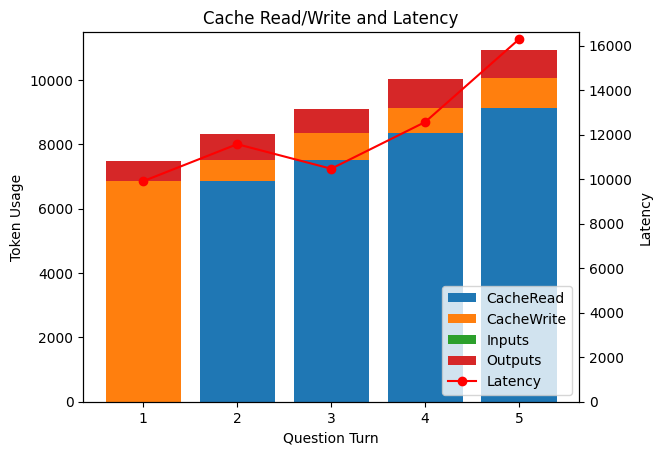

In [9]:
df = conversation.get_usage()
columns_to_stack = ["CacheRead", "CacheWrite", "Inputs", "Outputs"]

import matplotlib.pyplot as plt
# Create figure with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot stacked bars on first y-axis
bottom_stack = [0] * len(df)
for column in columns_to_stack:
    ax1.bar(df.index, df[column], bottom=bottom_stack, label=column)
    bottom_stack = [sum(x) for x in zip(bottom_stack, df[column])]

# Plot line on second y-axis  
ax2.plot(df.index, df['LatencyMs'], color='red', marker='o', label='Latency')

# Set labels and title
ax1.set_xlabel("Question Turn")
ax1.set_ylabel("Token Usage")
ax2.set_ylabel("Latency")
plt.title("Cache Read/Write and Latency")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.xticks(df.index, labels=(df.index + 1), rotation=0)
plt.ylim(0)
plt.show()